# Mitigating Bias with the XAI Toolbox
## **Exercise**: _Interpreting & Improving Fairness metrics_
### Workshop for DPhi Live Sessions — scheduled for December 4th, 2021 2:30 PM CET
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader) ) 

> ### EXCLUSIVE LIMITED-TIME OFFER
> This notebook demonstrates several of the methods in the book "Interpretable Machine Learning with Python".
> You can get it with a discount on Amazon UK only for a limited time:
>
> - **Edition**: Printed Edition Only (pre-order)
> - **Start Date**: 6th December 2021
> - **End Date**: 19th Dcemeber 2021
> - **Discount**: 25%
> - **Link**: https://packt.link/h4dGd

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn matplotlib seaborn tensorflow

Always installed unless installed already:

In [ ]:
#NOTE: It will show an error in Colab for xai 0.0.5. It will work regardless. 
# XAI doesn't really need exact versions of 6 different libraries to work.
!pip install --upgrade --quiet catboost
!pip install --no-deps git+https://github.com/EthicalML/xai.git
!pip install aif360==0.4.0

## 2) Load Libraries

In [1]:
%matplotlib inline
import math
import os, sys
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from aif360.sklearn.datasets import fetch_adult

#MODELING
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import catboost as cb
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#FAIRNESS
import xai
from aif360.sklearn.metrics import statistical_parity_difference, disparate_impact_ratio,\
                                   generalized_fpr, generalized_fnr
from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

#INTERPRETATION
from sklearn import metrics
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

## 3) Data Understanding

### 3.1) Load Dataset

In [2]:
X, y, _ = fetch_adult()

### 3.2) Inspect Dataset

Inspect first rows for `X`:

In [3]:
X.head()

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
,race,sex,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States


and for `y`:

In [4]:
y.head()

   race       sex 
0  Non-white  Male    <=50K
1  White      Male    <=50K
2  White      Male     >50K
3  Non-white  Male     >50K
5  White      Male    <=50K
Name: annual-income, dtype: category
Categories (2, object): ['<=50K' < '>50K']

### 3.3) Check Imbalanced

It's an imbalanced dataset since about 25% belongs to the positive class:

In [5]:
len(y[y=='>50K'])/len(y)

0.2478439697492371

but let's see how this is distributed across both genders by creating a simple dataframe...

In [6]:
y_by_sex_df = y.to_frame().reset_index().drop(['level_0','race'], axis=1)
y_by_sex_df.head(5)

,sex,annual-income
0,Male,<=50K
1,Male,<=50K
2,Male,>50K
3,Male,>50K
4,Male,<=50K


..and then grouping by and dividing:

In [7]:
y_by_sex_df.groupby(['sex','annual-income']).size()/y_by_sex_df.groupby(['sex']).size()

sex     annual-income
Female  <=50K            0.886424
        >50K             0.113576
Male    <=50K            0.687523
        >50K             0.312477
dtype: float64

Income distribution is very uneven among both genders. An easier way to visualize this imbalance is with an `imbalance_plot`:

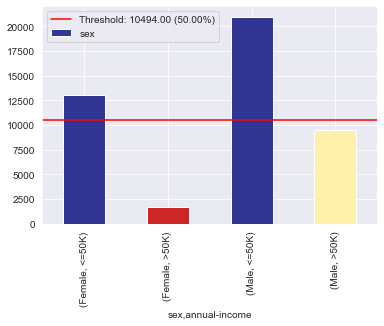

In [8]:
sns.set_style("darkgrid")
xai.imbalance_plot(y_by_sex_df, "sex", "annual-income",\
                   categorical_cols=["sex", "annual-income"])

### 3.4) Some Data Preparation Steps

First let's join `X` and `y` before we transform them:

In [9]:
all_df = X.join(y.to_frame().rename(columns={0:'annual-income'}))

Then we are to encode the indexes for `X` and `y`:

In [10]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

Define a seed for reproducibility:

In [11]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

and test/train split:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)

Before we one hot encode our features let's save the originals for `test` and `train`:

In [13]:
train_idxs = X_train.index.get_level_values(0).tolist()
train_df = all_df[all_df.index.get_level_values(0).isin(train_idxs)]
test_df = all_df[~all_df.index.get_level_values(0).isin(train_idxs)]

and then one hot encode:

In [14]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
        remainder='passthrough')
X_train  = pd.DataFrame(ohe.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), index=X_test.index)

X_train.head()

,,,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
,race,sex,,,,,,,,,,,,,,,,,,,,,
28065,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,38.0,14.0,7298.0,0.0,60.0
43124,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,47.0,9.0,0.0,1977.0,45.0
41428,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,43.0,13.0,0.0,0.0,50.0
12494,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,42.0,16.0,0.0,0.0,40.0
7756,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,26.0,9.0,0.0,0.0,40.0


### 3.5) Quantifying Dataset Bias

It's easy to compute fairness metrics in a training dataset. All you need is the label:

In [15]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_train, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_train, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.2001
Disparate Impact (DI):					0.3637


Now, let's explain what each metric means:

- **Statistical Parity Difference** (**SPD**): also know as the **Mean Difference** is the difference between the mean probability of favorable outcomes between underpriviledged and priviledged groups. A negative number is bad and a positive number is better yet a number closer to zero is always preferable. It's computed with the following formula where $f$ is the value for the favorable class.

$Pr(Y = f | D = \text{unprivileged})
           - Pr(Y = f | D = \text{privileged})$
  
- **Disparate Impact** (**DI**)): Disparate impact is exactly like _Statistical Parity Difference_ except it's the ratio not the difference. And as ratios go, the closer to one the better and under one would mean disadvantage and over one means advantage.

$\frac{Pr(Y = f | D = \text{unprivileged})}
           {Pr(Y = f | D = \text{privileged})}$

## 4) Modeling & Evaluation

### 4.1) Define Utility Functions

In [19]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    if plot:
        plt.figure(figsize = (12,12))
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
        plt.xlabel('False Positive Rate', fontsize = 14)
        plt.ylabel('True Positive Rate', fontsize = 14)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc="lower right")
        plt.show()
    print('Accuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                        (metrics.accuracy_score(y_train, y_train_pred),\
                         metrics.accuracy_score(y_test, y_test_pred)))
    print('Precision_test:  %.4f\t\tRecall_test:     %.4f' %\
                        (metrics.precision_score(y_test, y_test_pred),\
                         metrics.recall_score(y_test, y_test_pred)))
    print('ROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                        (roc_auc,\
                         metrics.f1_score(y_test, y_test_pred),\
                         metrics.matthews_corrcoef(y_test, y_test_pred)))
    cf_matrix = metrics.confusion_matrix(y_test,\
                                         y_test_pred)
    if plot:
        plt.figure(figsize=(6, 5))
        if pct:
            sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        plt.show()
    return y_train_pred, y_test_prob, y_test_pred

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):
    """Compare two confusion matrices and display FPR ratio metrics. 
    Return FPR ratio between matrices.
    
    Keyword arguments:
    y_true_1 -- ground truth values for first confusion matrix (pandas series or 1D array)
    y_pred_1 -- predictions for first confusion matrix  (pandas series or 1D array)
    y_true_2 -- ground truth values for second confusion matrix (pandas series or 1D array)
    y_pred_2 -- predictions for second confusion matrix  (pandas series or 1D array)
    group_1 -- name of group represented by first matrix (string)
    group_2 -- name of group represented by second matrix (string)
    plot -- whether to plot the confusion matrices or not (boolean)
    """
    
    #Create confusion matrices for two different groups.
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    #Plot both confusion matrices side-by-side.
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        plt.show()

    #Calculate False Positive Rates (FPR) for each Group.
    tn, fp, fn, tp = conf_matrix_1.ravel()
    fpr_1 = fp/(fp+tn)
    fnr_1 = fn/(fn+tp)
    tn, fp, fn, tp = conf_matrix_2.ravel()
    fpr_2 = fp/(fp+tn)
    fnr_2 = fn/(fn+tp)

    #Print the FPRs and the ratio between them.
    if compare_fpr:
        if fpr_2 > fpr_1:
            print("\t" + group_2 + " FPR:\t%.1f%%" % (fpr_2*100))
            print("\t" + group_1 + " FPR:\t\t%.1f%%" % (fpr_1*100))
            print("\tRatio FPRs:\t\t%.2f x" % (fpr_2/fpr_1))
            return (fpr_2/fpr_1)
        else:
            print("\t" + group_1 + " FPR:\t%.1f%%" % (fpr_1*100))
            print("\t" + group_2 + " FPR:\t\t%.1f%%" % (fpr_2*100))
            print("\tRatio FPRs:\t\t%.2f x" % (fpr_1/fpr_2))
            return (fpr_1/fpr_2)
    else:
        if fnr_2 > fnr_1:
            print("\t" + group_2 + " FNR:\t%.1f%%" % (fnr_2*100))
            print("\t" + group_1 + " FNR:\t\t%.1f%%" % (fnr_1*100))
            print("\tRatio FNRs:\t\t%.2f x" % (fnr_2/fnr_1))
            return (fnr_2/fnr_1)
        else:
            print("\t" + group_1 + " FNR:\t%.1f%%" % (fnr_1*100))
            print("\t" + group_2 + " FNR:\t\t%.1f%%" % (fnr_2*100))
            print("\tRatio FNRs:\t\t%.2f x" % (fnr_1/fnr_2))
            return (fnr_1/fnr_2)

### 4.2) Train & Evaluate Base Models

#### 4.2.1) Logistic Regression

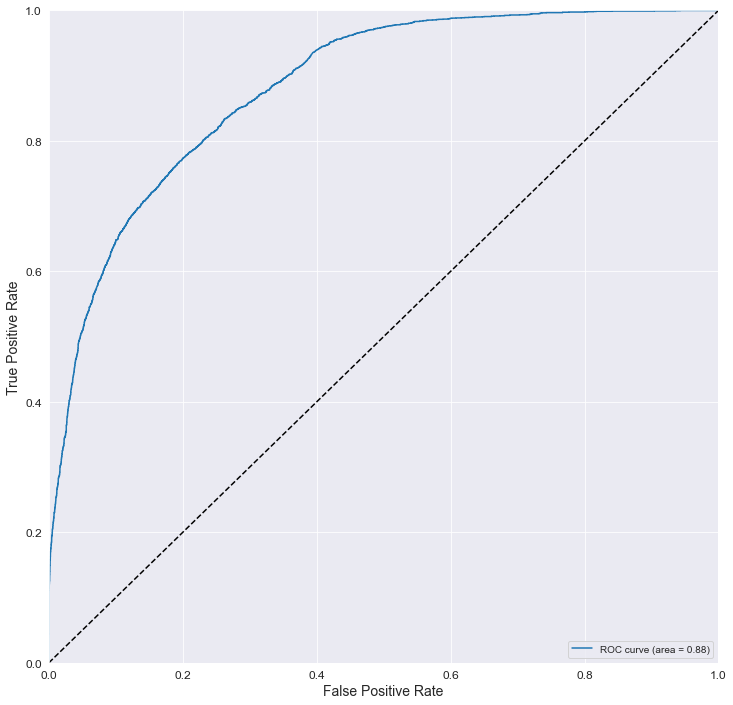

Accuracy_train:  0.8374		Accuracy_test:   0.8420
Precision_test:  0.7258		Recall_test:     0.5716
ROC-AUC_test:    0.8822		F1_test:         0.6395		MCC_test: 0.5465


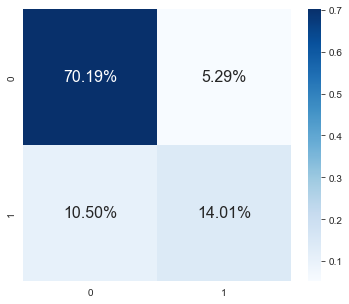

In [20]:
lr_mdl = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

y_train_lr_pred, y_test_lr_prob, y_test_lr_pred =\
                                        evaluate_class_mdl(lr_mdl, X_train, X_test, y_train, y_test)

#### 4.2.2) CatBoost Classifier

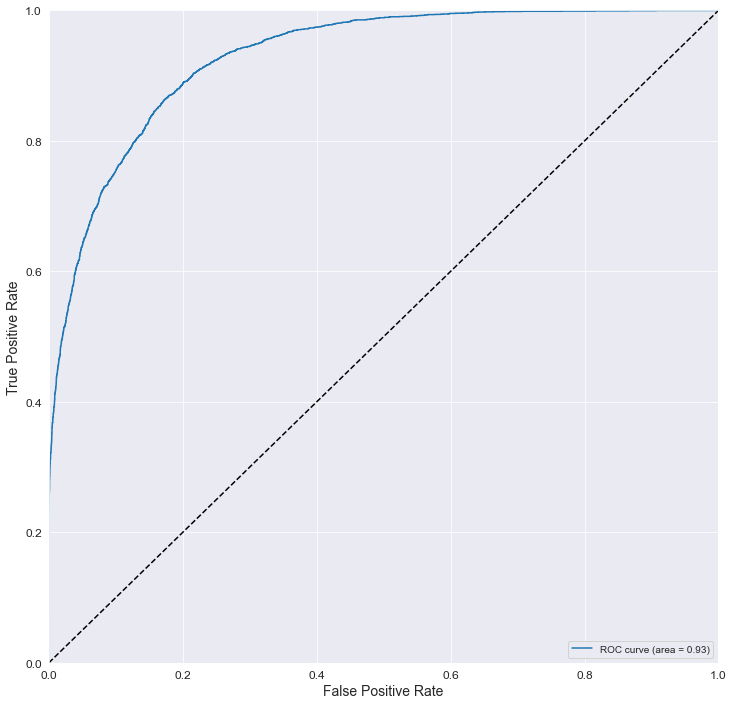

Accuracy_train:  0.8886		Accuracy_test:   0.8739
Precision_test:  0.7935		Recall_test:     0.6563
ROC-AUC_test:    0.9288		F1_test:         0.7184		MCC_test: 0.6429


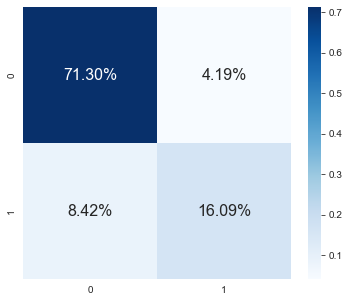

In [21]:
cb_mdl = cb.CatBoostClassifier(verbose=0,\
                                random_state=rand).fit(X_train, y_train) #, scale_pos_weight=0.95

y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
                                        evaluate_class_mdl(cb_mdl, X_train, X_test, y_train, y_test)

### 4.3) Visualize/Detect Model Bias

There are many ways to do this but for a binary classifier the easiest way to do this is by comparing confusion matrices side by side.

To do this, first let's get a boolean series for male so we can subset our labels and predictions by whether they are for a male or a female:

In [22]:
is_male = y_test.index.get_level_values('sex') == 1

Then we use our plotting function to compare the confusion matrices for male and female for the Logistic Regression model:

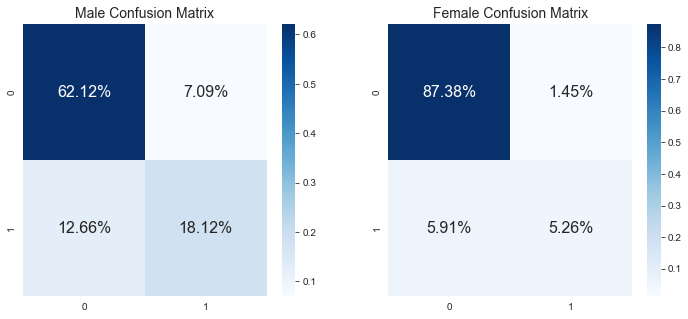

	Female FNR:	52.9%
	Male FNR:		41.1%
	Ratio FNRs:		1.29 x


In [23]:
_ = compare_confusion_matrices(y_test[is_male], y_test_lr_pred[is_male],\
                               y_test[~is_male], y_test_lr_pred[~is_male], 'Male', 'Female',\
                               compare_fpr=False)

Now, we can do the same for Catboost:

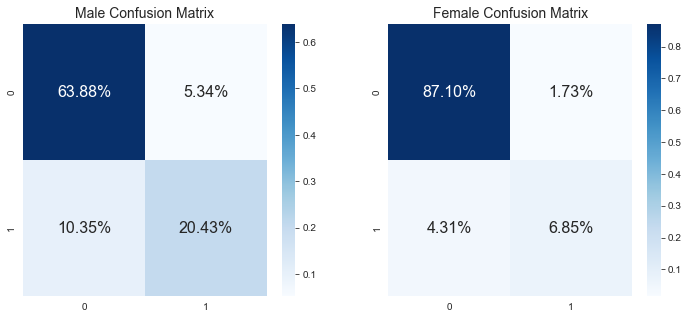

	Female FNR:	38.6%
	Male FNR:		33.6%
	Ratio FNRs:		1.15 x


In [24]:
_ = compare_confusion_matrices(y_test[is_male], y_test_cb_pred[is_male],\
                               y_test[~is_male], y_test_cb_pred[~is_male], 'Male', 'Female',\
                               compare_fpr=False)

As you can see both compute the false negative rate (FNR) for male and female and then the ratio between these both to determine how much more likely one is to get false negatives over the other.

False negative rate is computed like this:

$\text{FNR} = \large{\frac{\text{FN}}{\text{FN} + \text{TP}}}$

### 4.4) Quantifying Model Bias

It's done in `AIF360` exactly the same way as with dataset bias except you add the predicted labels as well. Here we have it for Logistic regression:

In [33]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_test, y_test_lr_pred, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_test, y_test_lr_pred, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.1850
Disparate Impact (DI):					0.2663


...and this is for Catboost:

In [34]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_test, y_test_cb_pred, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_test, y_test_cb_pred, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.1718
Disparate Impact (DI):					0.3331


You can tell Disparate Impact is worse than it was with the dataset. This is expect since models tend to amplify dataset biases.

## 5) Mitigating Bias

### 5.1) via Pre-Processing method

**Preprocessing**: These are interventions to detect and remove bias from the training data before training the model. Methods that leverage preprocessing have the advantage that they tackle bias at the source. On the other hand, any undetected bias is still amplified by the model.

**Reweighing**: Much like class weights are applied to each class, sample weights are applied to each observation or sample. Many regressors and classifiers, CatBoostClassifier included, support sample weights. Even though technically, reweighting doesn't touch the data and solution applied to the model, it is a preprocessing method because we detected bias in the data.

Since it could take a longer while with our best classifier, we will reweight for Logistic regression in a grid search and then evaluate:

In [35]:
%%time
rw = ReweighingMeta(estimator=LogisticRegression(solver='lbfgs'))

params = {'estimator__C': [1,10], 'reweigher__prot_attr': ['sex']}

lr_rw_mdl = GridSearchCV(rw, params, scoring='accuracy', cv=5)
lr_rw_mdl = lr_rw_mdl.fit(X_train, y_train)

y_train_lr_rw_pred, y_test_lr_rw_prob, y_test_lr_rw_pred =\
                                        evaluate_class_mdl(lr_rw_mdl, X_train, X_test, y_train, y_test,\
                                                           plot=False)

Accuracy_train:  0.8324		Accuracy_test:   0.8359
Precision_test:  0.7325		Recall_test:     0.5210
ROC-AUC_test:    0.8734		F1_test:         0.6089		MCC_test: 0.5206
CPU times: user 31 s, sys: 7.92 s, total: 38.9 s
Wall time: 5.09 s


The reweighting has impacted performance slightly but improved the fairness metrics:

In [36]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_test, y_test_lr_rw_pred, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_test, y_test_lr_rw_pred, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.1200
Disparate Impact (DI):					0.4361


It works but assigning different weights to each observation:

In [37]:
_, sample_weight = rw.reweigher.fit_transform(X_train, y_train)

As you see here they all vary:

In [38]:
sample_weight

array([0.7660164 , 0.7660164 , 0.7660164 , ..., 1.11268671, 0.856608  ,
       1.11268671])

You would think that adding weights to observations would greatly impact predictive performance. However, this method was designed to maintain balance. In an unweighted dataset, all observations have a weight of one, and therefore the average of all the weights is one. While reweighting changes the weights for observations, the mean is still approximately one:

In [39]:
np.mean(sample_weight)

0.9999999999999998

### 5.2) via In-Processing method

**In-processing**: These methods mitigate bias during the model training and are, therefore, highly dependent on the model and tend to not be model-agnostic like the preprocessing and post-processing methods. They also require hyperparameter tuning to calibrate fairness metrics.

**Adversarial debiasing**: It leverages two opposing actors, but this time it's with two neural networks: a predictor and an adversary. We maximize the predictor's ability to predict the target while minimizing the adversary's ability to predict the protected feature, thus increasing equality of odds between privileged and underprivileged groups.

This method leverages neural networks so once we fit and evaluate the model we will close the `tensorflow` session:

In [40]:
adv_deb_mdl = AdversarialDebiasing(prot_attr='sex', random_state=rand)
adv_deb_mdl = adv_deb_mdl.fit(X_train, y_train)
y_train_adv_deb_pred, y_test_adv_deb_prob, y_test_adv_deb_pred =\
                                        evaluate_class_mdl(adv_deb_mdl, X_train, X_test, y_train, y_test,\
                                                           plot=False)
adv_deb_mdl.sess_.close()

2021-12-03 22:44:48.333058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Accuracy_train:  0.8339		Accuracy_test:   0.8315
Precision_test:  0.6667		Recall_test:     0.6254
ROC-AUC_test:    0.8871		F1_test:         0.6454		MCC_test: 0.5355


Then, evaluate it as we have before:

In [41]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_test, y_test_adv_deb_pred, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_test, y_test_adv_deb_pred, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.1121
Disparate Impact (DI):					0.5782


### 5.3) via Post-Processing method
#### (combined with pre-processing)

**Post-processing**: These methods mitigate bias during model inference. Post-processing methods aim to detect and correct fairness directly in the outcomes, but what adjustments to make will depend on which metrics matter most to your problem. They have the advantage that they can tackle outcome unfairness where it can have the greatest impact, but since it's disconnected from the rest of the model development, it can distort things.

**Calibrated equalized odds postprocessing**: Instead of changing the labels, this method modifies the probability estimates so that they are on average equal. It calls this calibration. However, this constraint cannot be satisfied for false-positives and false-negatives concurrently, so you are forced to prefer one over the other. Therefore, it is advantageous in cases where recall is far more important than precision or vice-versa, and there are benefits to calibrating the
estimated probabilities.

In [42]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=rand)
cb_pp_mdl = PostProcessingMeta(estimator=cb.CatBoostClassifier(verbose=0, random_state=rand),\
                               postprocessor=cal_eq_odds, random_state=rand)
cb_pp_mdl = cb_pp_mdl.fit(X_train, y_train, sample_weight=sample_weight)

y_train_cb_pp_pred, y_test_cb_pp_prob, y_test_cb_pp_pred =\
                                        evaluate_class_mdl(cb_pp_mdl, X_train, X_test, y_train, y_test,\
                                                           plot=False)

Accuracy_train:  0.8757		Accuracy_test:   0.8637
Precision_test:  0.8063		Recall_test:     0.5845
ROC-AUC_test:    0.9099		F1_test:         0.6777		MCC_test: 0.6064


Combining post-processing with pre-processing, yields some good results:

In [43]:
print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      statistical_parity_difference(y_test, y_test_cb_pp_pred, prot_attr='sex'))
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      disparate_impact_ratio(y_test, y_test_cb_pp_pred, prot_attr='sex'))

Statistical Parity Difference (SPD):			-0.1123
Disparate Impact (DI):					0.4743


This is specially visible with the confusion matrices:

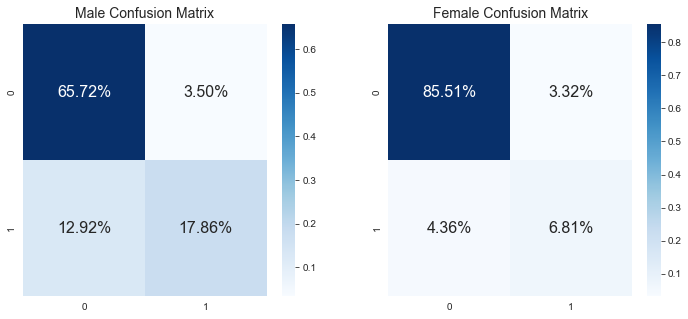

	Male FNR:	42.0%
	Female FNR:		39.0%
	Ratio FNRs:		1.07 x


In [44]:
rf_fnr = compare_confusion_matrices(y_test[is_male], y_test_cb_pp_pred[is_male],\
                                    y_test[~is_male], y_test_cb_pp_pred[~is_male], 'Male', 'Female',\
                                    compare_fpr=False)

### 5.4) Before & After

#### 5.4.1) Before

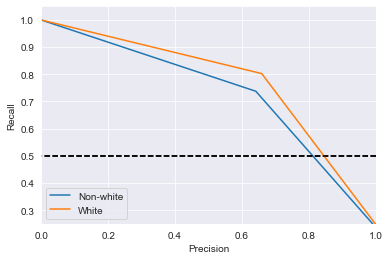

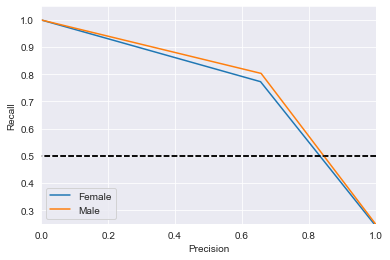

In [56]:
protected_cols_l = ["race", "sex"]
for p in protected_cols_l:
    _ = xai.pr_plot(
        y_test.tolist(), 
        y_test_cb_pred, 
        df=test_df.reset_index(drop=True), 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

#### 5.4.2) After

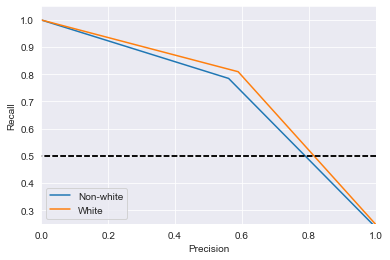

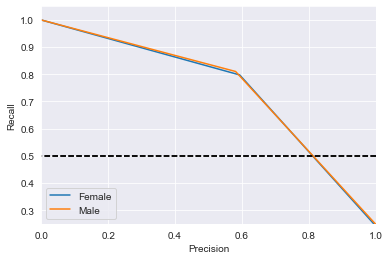

In [55]:
protected_cols_l = ["race", "sex"]
for p in protected_cols_l:
    _ = xai.pr_plot(
        y_test.tolist(), 
        y_test_cb_pp_pred, 
        df=test_df.reset_index(drop=True), 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

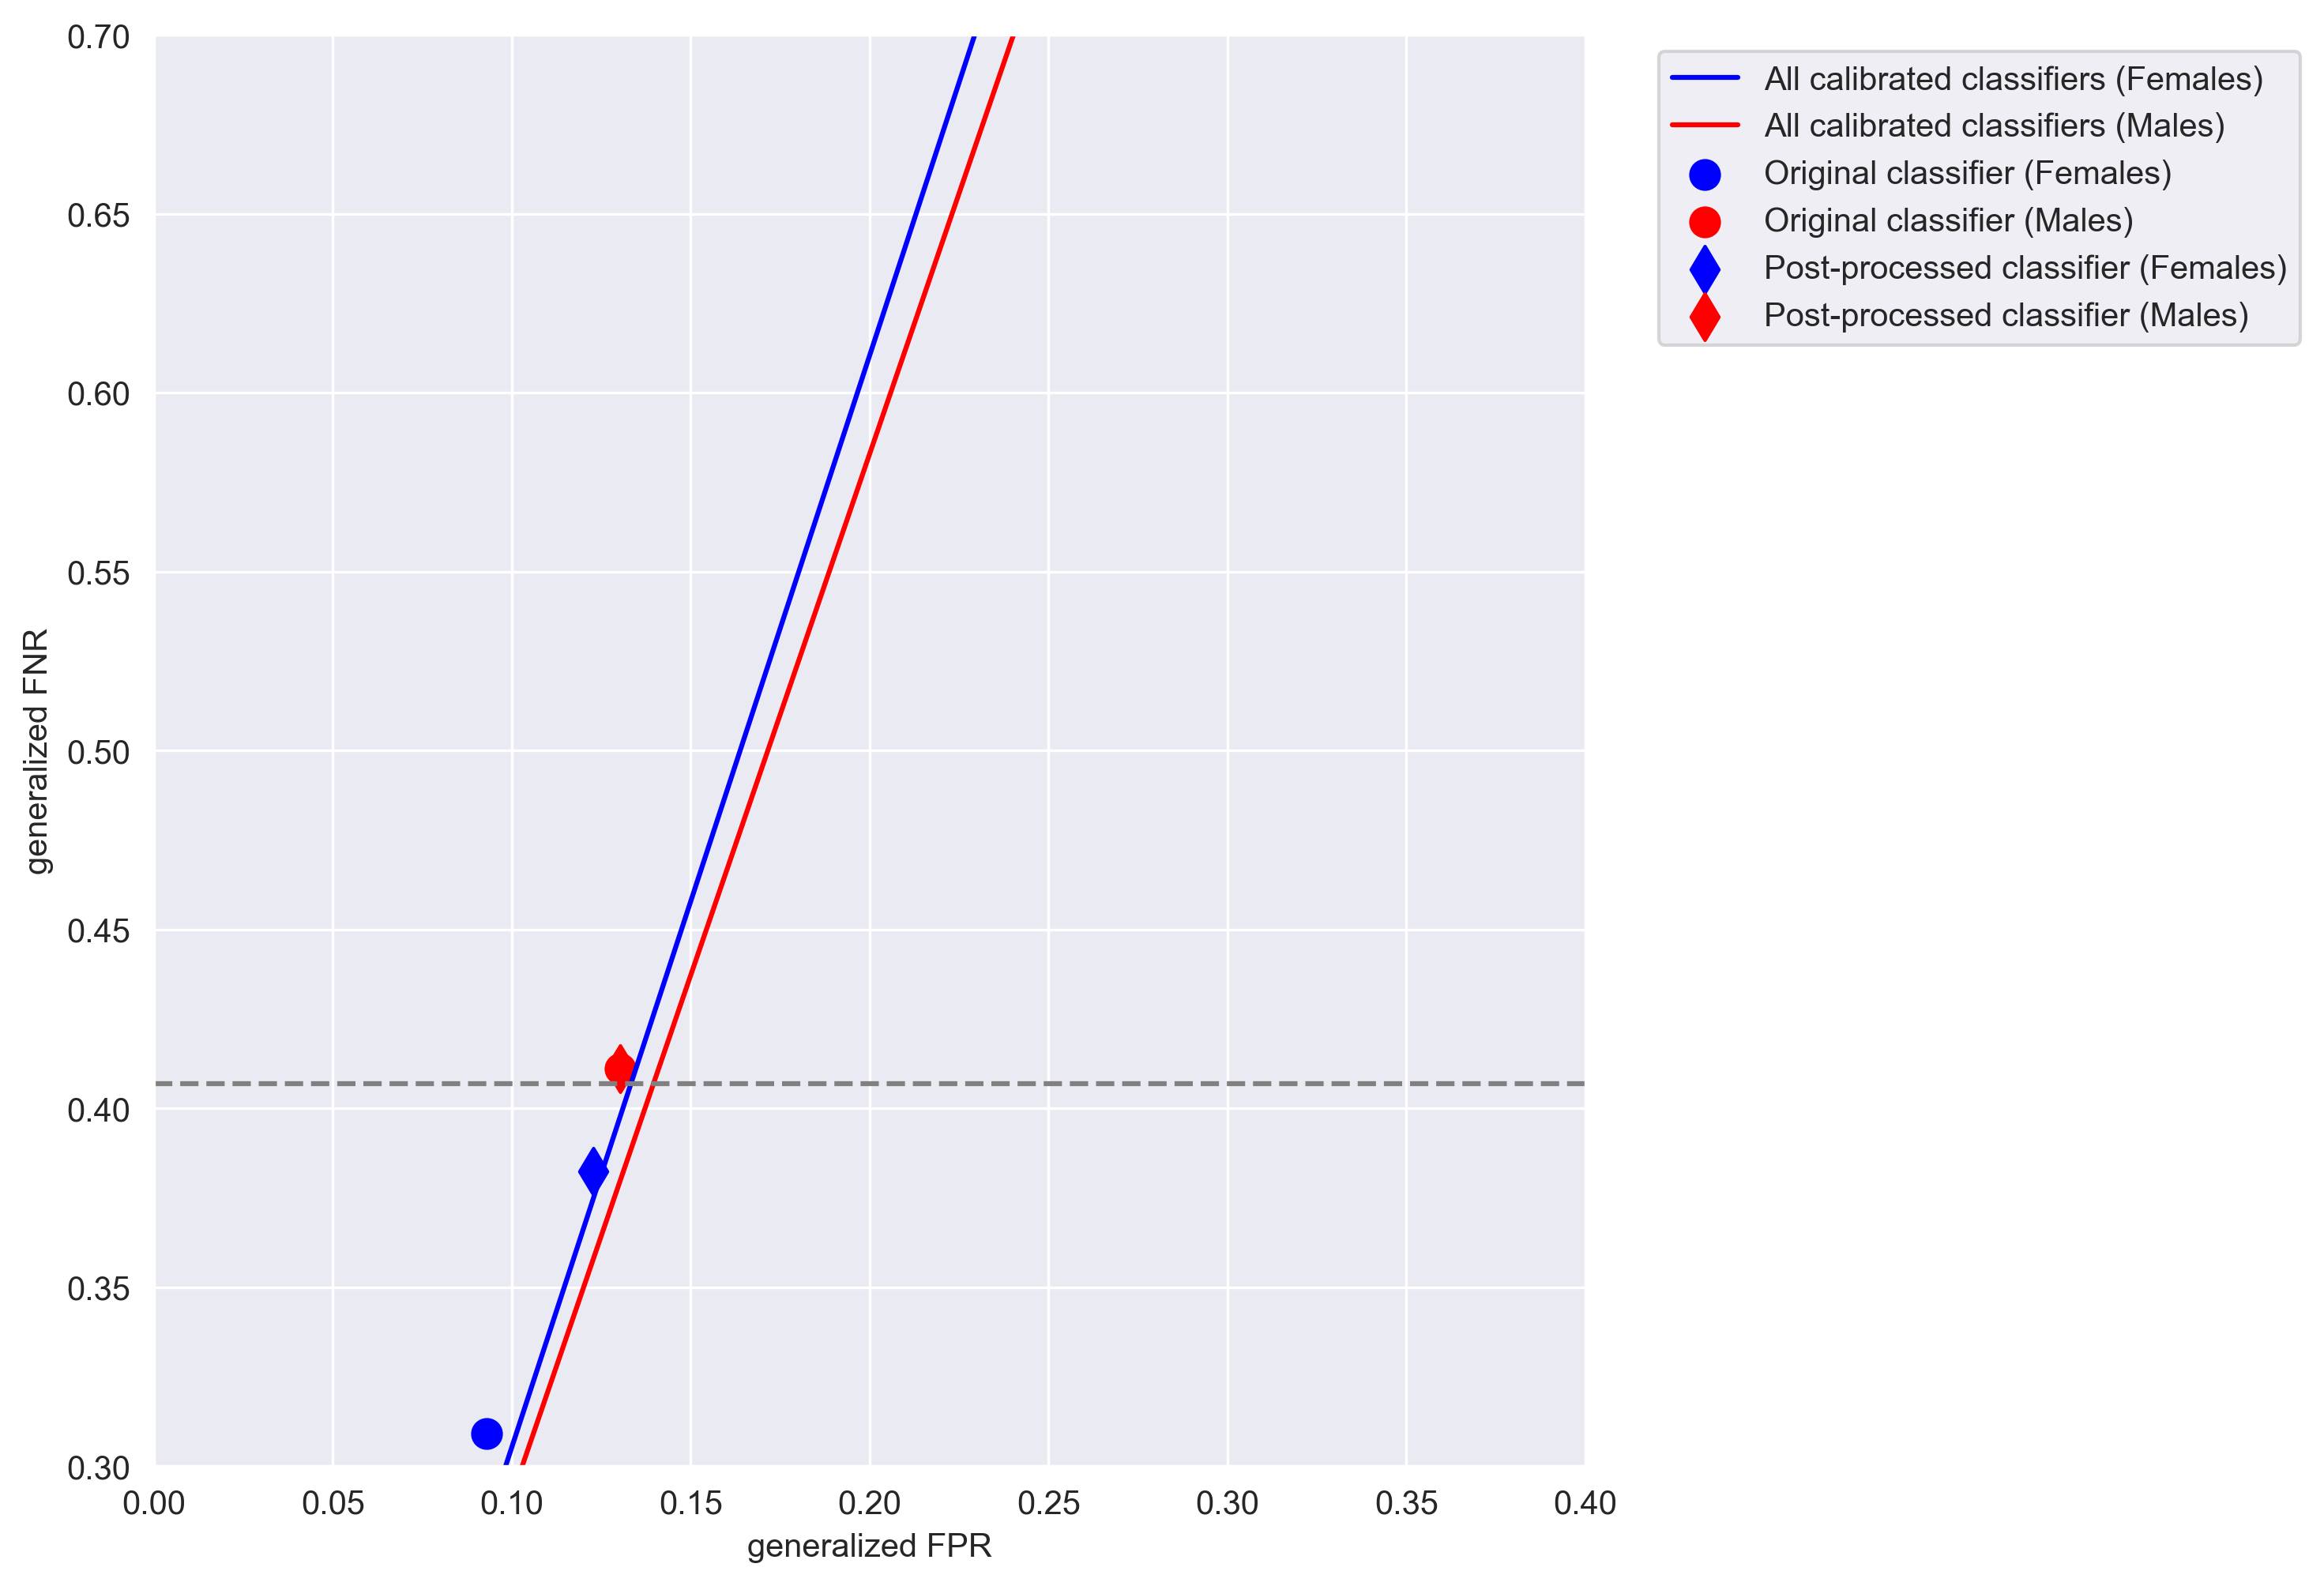

In [ ]:
y_orig_prob = cb_pp_mdl.estimator_.predict_proba(X_test)[:, 1]
base_rates = cb_pp_mdl.postprocessor_.base_rates_

plt.figure(figsize=(12, 8), dpi=300)
plt.plot([0, base_rates[0]], [0, 1-base_rates[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, base_rates[1]], [0, 1-base_rates[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_orig_prob[~is_male]),
            generalized_fnr(y_test[~i], y_orig_prob[~is_male]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_orig_prob[is_male]),
            generalized_fnr(y_test[i], y_orig_prob[is_male]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_test_cb_pp_prob[~is_male]),
            generalized_fnr(y_test[~i], y_test_cb_pp_prob[~is_male]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_test_cb_pp_prob[is_male]),
            generalized_fnr(y_test[i], y_test_cb_pp_prob[is_male]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized FPR');
plt.ylabel('generalized FNR');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');